In [35]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as tsa


from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
import os
warnings.filterwarnings("ignore")

In [36]:
# df_main = pd.read_excel(engine="python","https://github.com/carrenogf/MCD-Series-Temporales/blob/64d7bd2271190301ac5419698736fec4ff37b342/dataset/series_diarias.xlsx")
df_main = pd.read_excel("https://raw.githubusercontent.com/carrenogf/MCD-Series-Temporales/main/dataset/series_diarias.xlsx")
df_main = df_main.sort_values("FECHA",ascending=True)
df_main.set_index("FECHA", inplace=True)
df_copa = df_main["CHU_COPA_AJUST"].dropna()
df_recprop = df_main["CHU_REC_PROPIOS_AJUST"].dropna()
df_regal = df_main["CHU_REGALIAS_AJUST"].dropna()

In [37]:
df_copa.head()


FECHA
2018-01-02    1.231307e+06
2018-01-03    2.875741e+06
2018-01-04    3.933965e+05
2018-01-05    7.066760e+05
2018-01-08    8.765211e+05
Name: CHU_COPA_AJUST, dtype: float64

In [38]:
df_recprop.head()

FECHA
2016-04-01     679233
2016-04-04     339379
2016-04-05     903634
2016-04-06     858197
2016-04-07    1774956
Name: CHU_REC_PROPIOS_AJUST, dtype: int64

In [39]:
df_regal.head()

FECHA
2016-04-08      212159.0
2016-04-14       26246.0
2016-04-15    16002725.0
2016-04-20        5582.0
2016-04-29    11066374.0
Name: CHU_REGALIAS_AJUST, dtype: float64

In [42]:
dataframes = [df_copa, df_recprop, df_regal]  # Asegúrate de definir estos dataframes

<h2>Ejercicio 1</h2>
Buscar 3 (tres) series de tiempo y exponer la problemática de interés analítico (es importante detallar cuáles fueron los motivos de elección y situar al lector en el contexto adecuado).

<h2>Ejercicio 2</h2>
Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias.

Exponer los conceptos relacionados con la estacionariedad de la serie.

In [40]:

def graficar(serie, titulo="", xlabel="Tiempo", ylabel="Tasa", ax=None):
    """Grafica una serie en un eje específico."""
    serie.plot(ax=ax)  # Graficar la serie en el subplot dado

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(titulo)
    ax.legend(loc='best')
    ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))



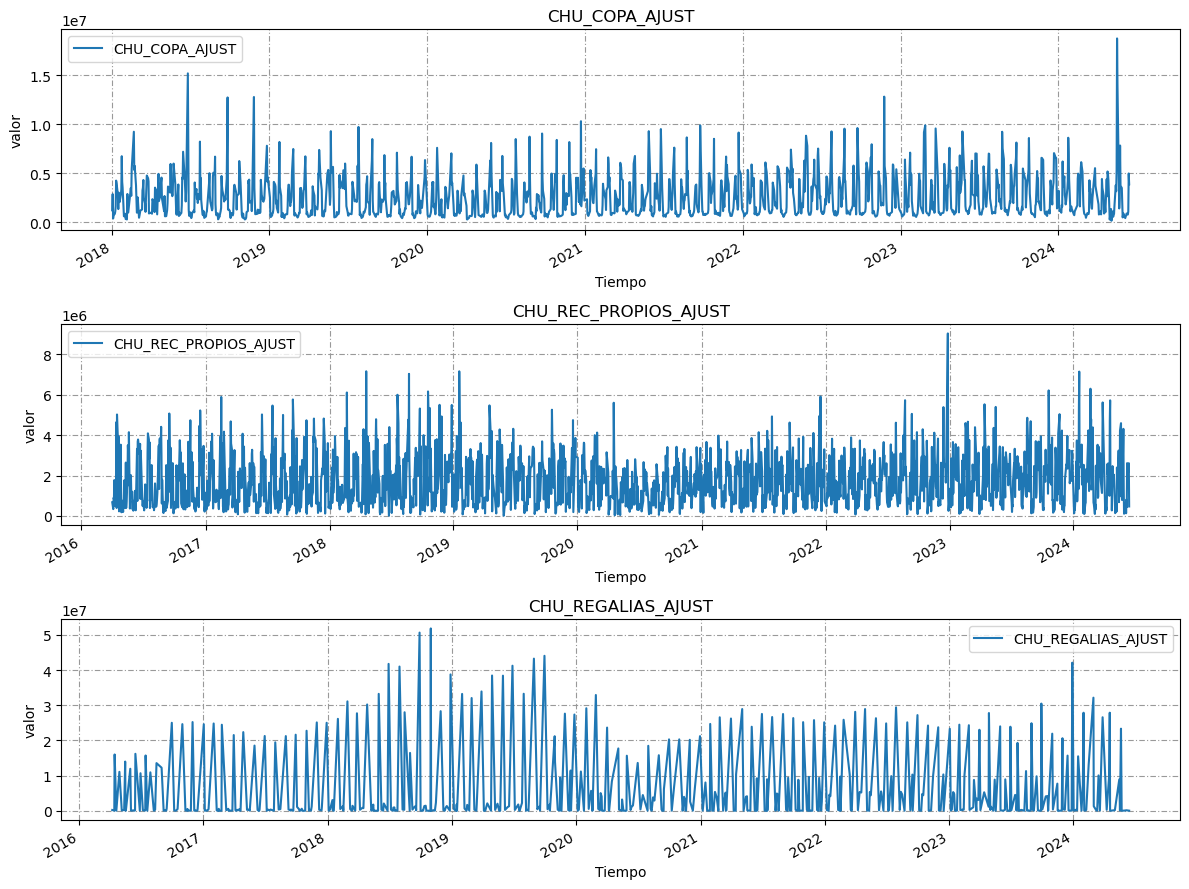

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), dpi=100)  # 3 filas, 1 columna

for i, (df, ax) in enumerate(zip(dataframes, axes)):
    graficar(serie=df,
             titulo=f"{df.name}",
             xlabel="Tiempo",
             ylabel="valor",
             ax=ax)

plt.tight_layout()  # Evitar superposición
plt.show()

In [43]:
# Esta función descompone la serie en sus partes para ver estacionalidad, tendencia, residuos
def componentes(timeserie, periodo):
  decomposition = seasonal_decompose(timeserie, model='additive', period=periodo)
  fig = plt.figure()
  fig = decomposition.plot()
  fig.set_size_inches(15, 8)

<Figure size 640x480 with 0 Axes>

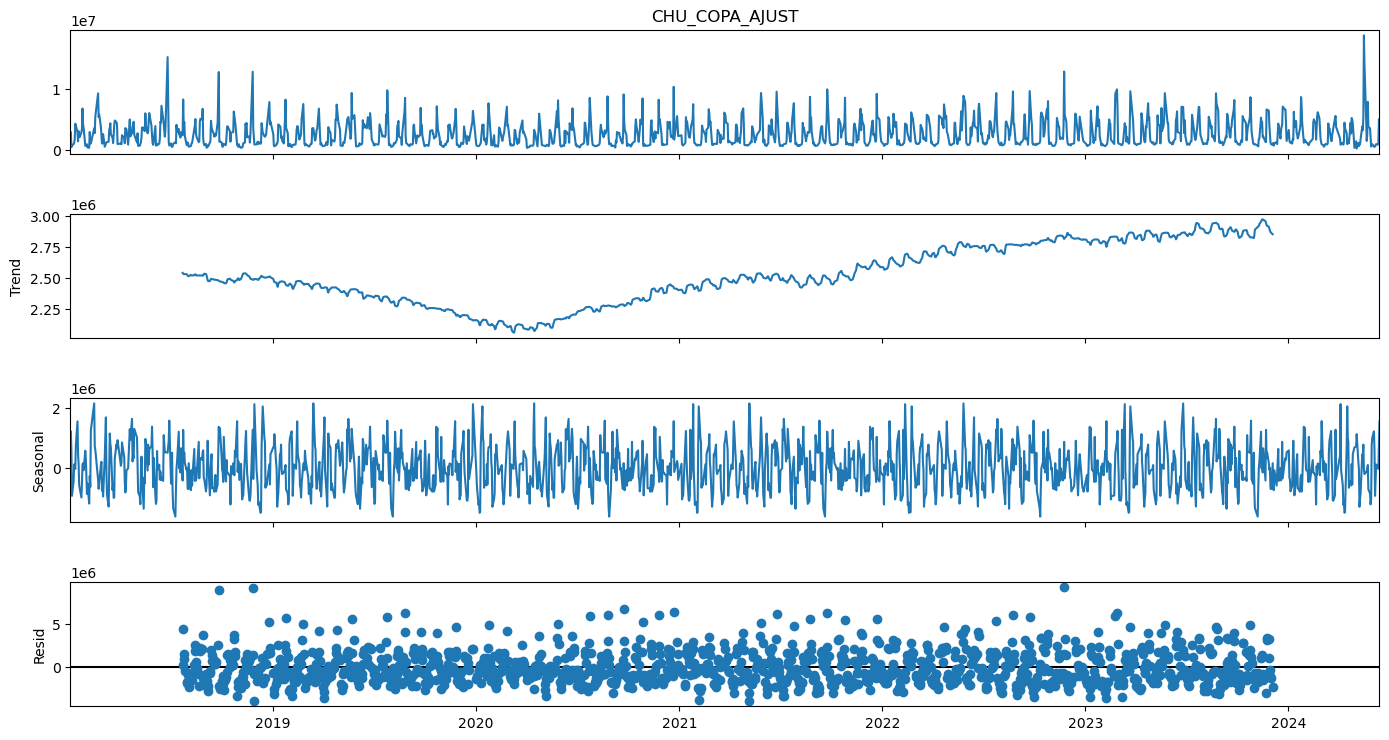

<Figure size 640x480 with 0 Axes>

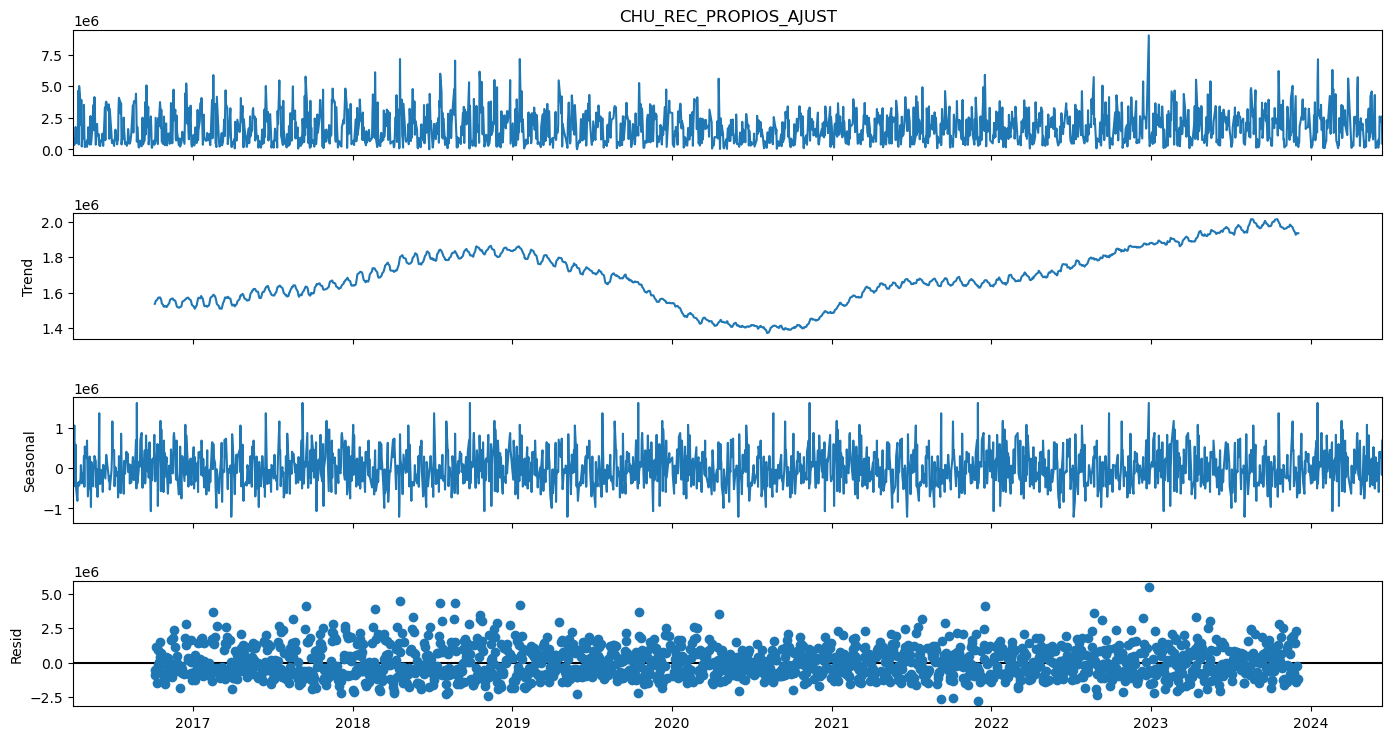

<Figure size 640x480 with 0 Axes>

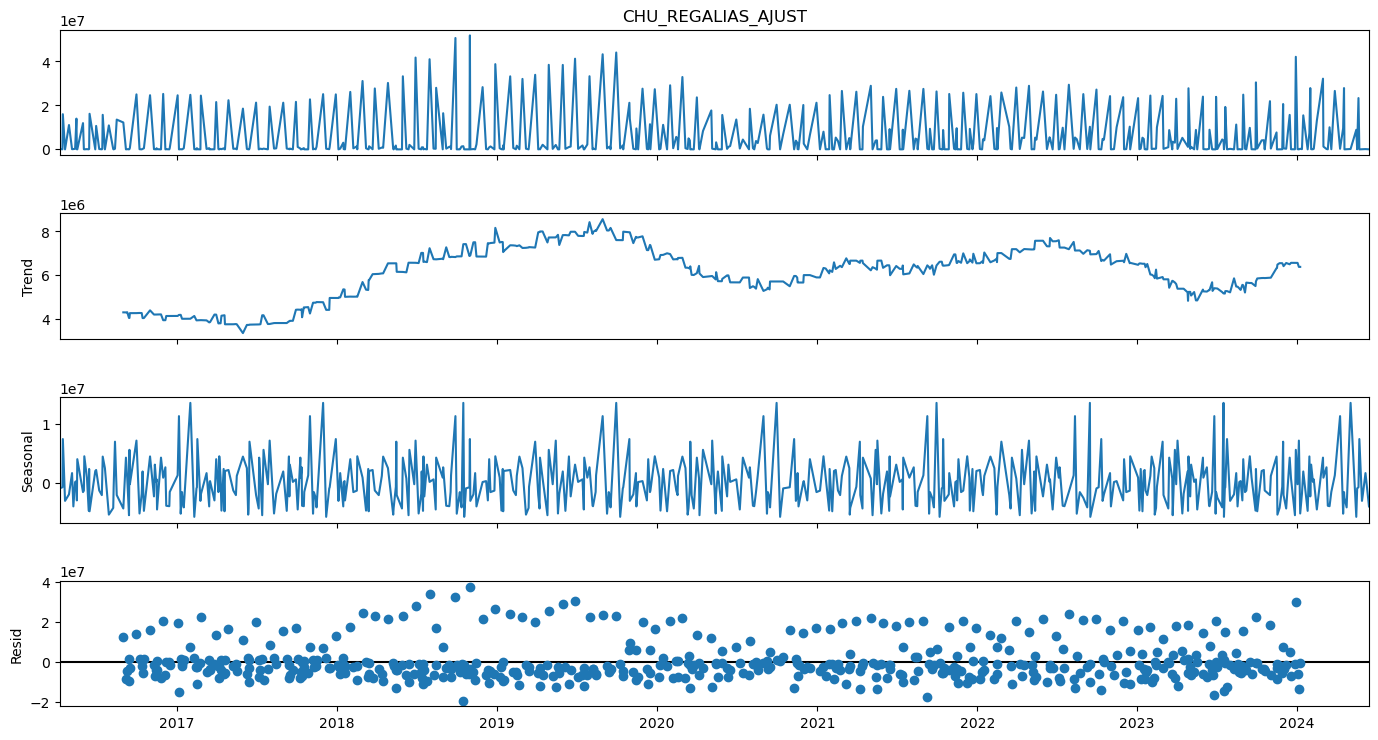

In [44]:
componentes(dataframes[0], 252)
componentes(dataframes[1], 252)
componentes(dataframes[2], 61)

<h2>Ejercicio 3</h2>
Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?.

Justificar con teoría.

In [46]:
## Función para dibujar juntos FAS: autocovarianzas; FAC y FACP, autocorrelación y autocorrelación parcial
def autocov_autocorr(serie_r, nrol=75,serie_titulo=""):
    fig, axes = plt.subplots(3, 1, figsize=(18, 10))

    plot_acf(serie_r, lags=nrol, ax=axes[0], color='blue', vlines_kwargs={"colors": 'blue'})
    axes[0].set_title(f'ACF (Autocorrelación) {serie_titulo}', fontsize=14)

    plot_pacf(serie_r, lags=nrol, ax=axes[1], color='green', vlines_kwargs={"colors": 'green'}, method='ywm')
    axes[1].set_title(f'PACF (Autocorrelación Parcial) {serie_titulo}', fontsize=14)

    axes[2].plot(tsa.acovf(serie_r, fft=False, nlag=nrol), color='red', label='AutoCov')
    axes[2].set_title(f'Autocovarianza {serie_titulo}', fontsize=14)
    axes[2].set_xlabel('Lag')

    plt.tight_layout()
    plt.show()

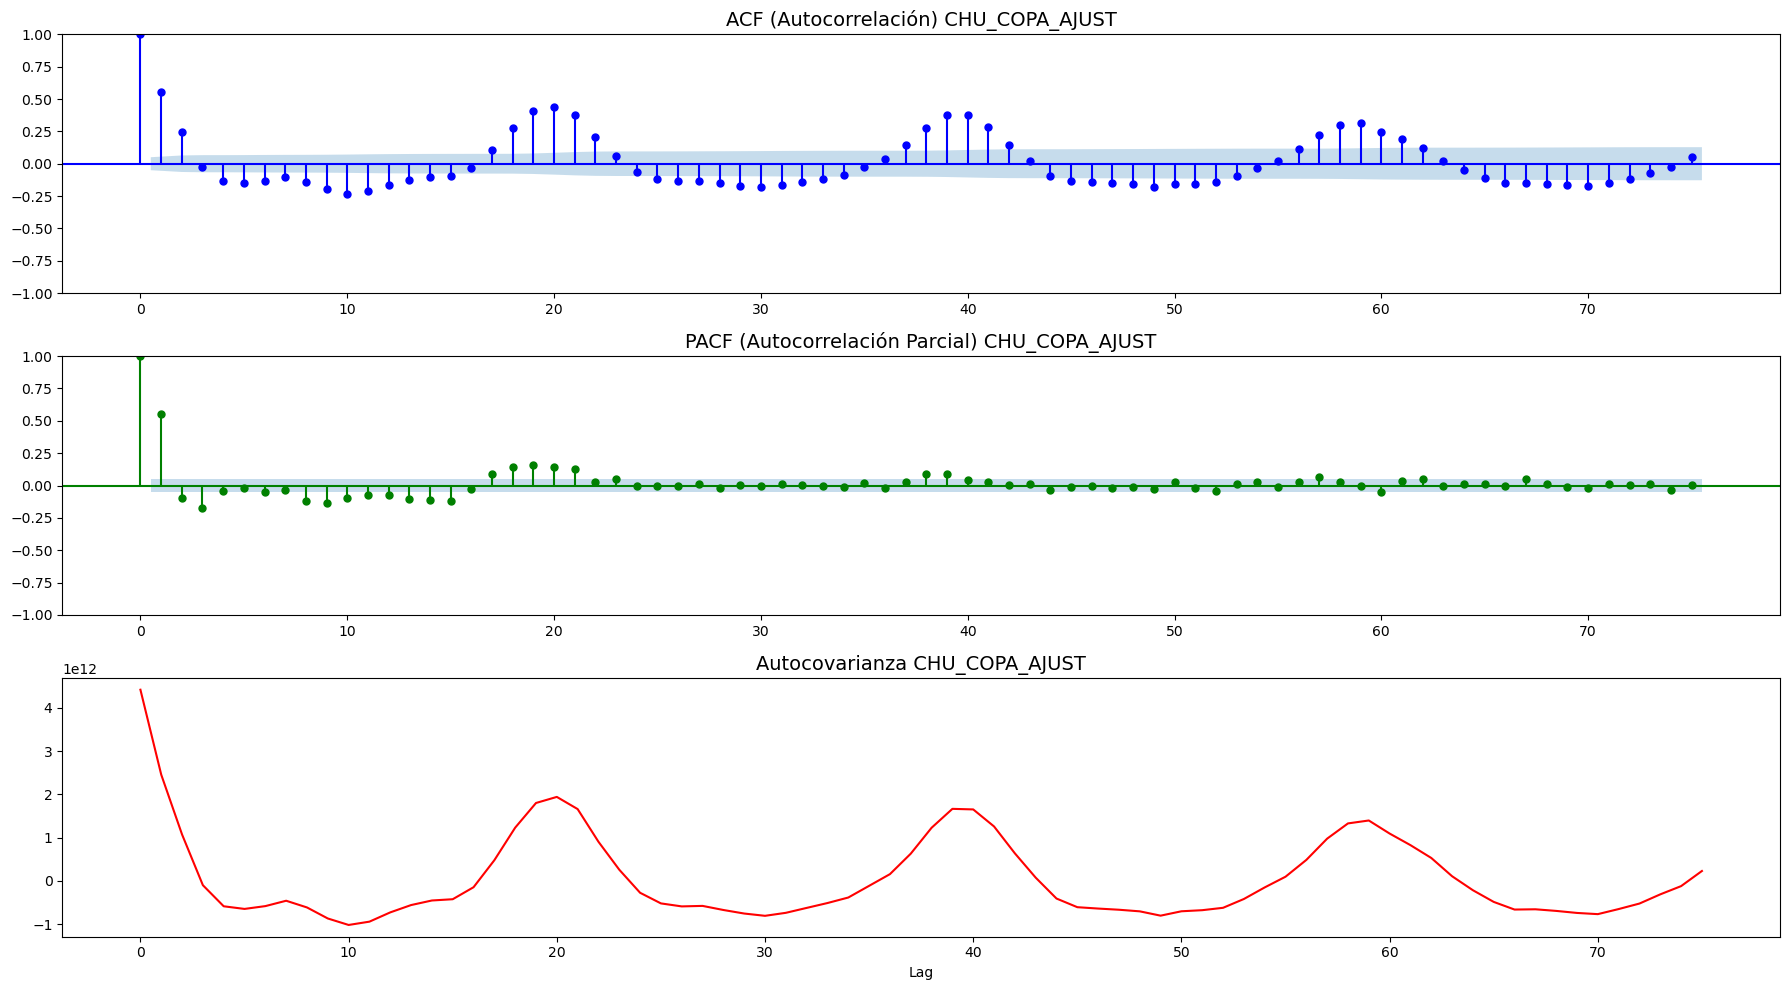

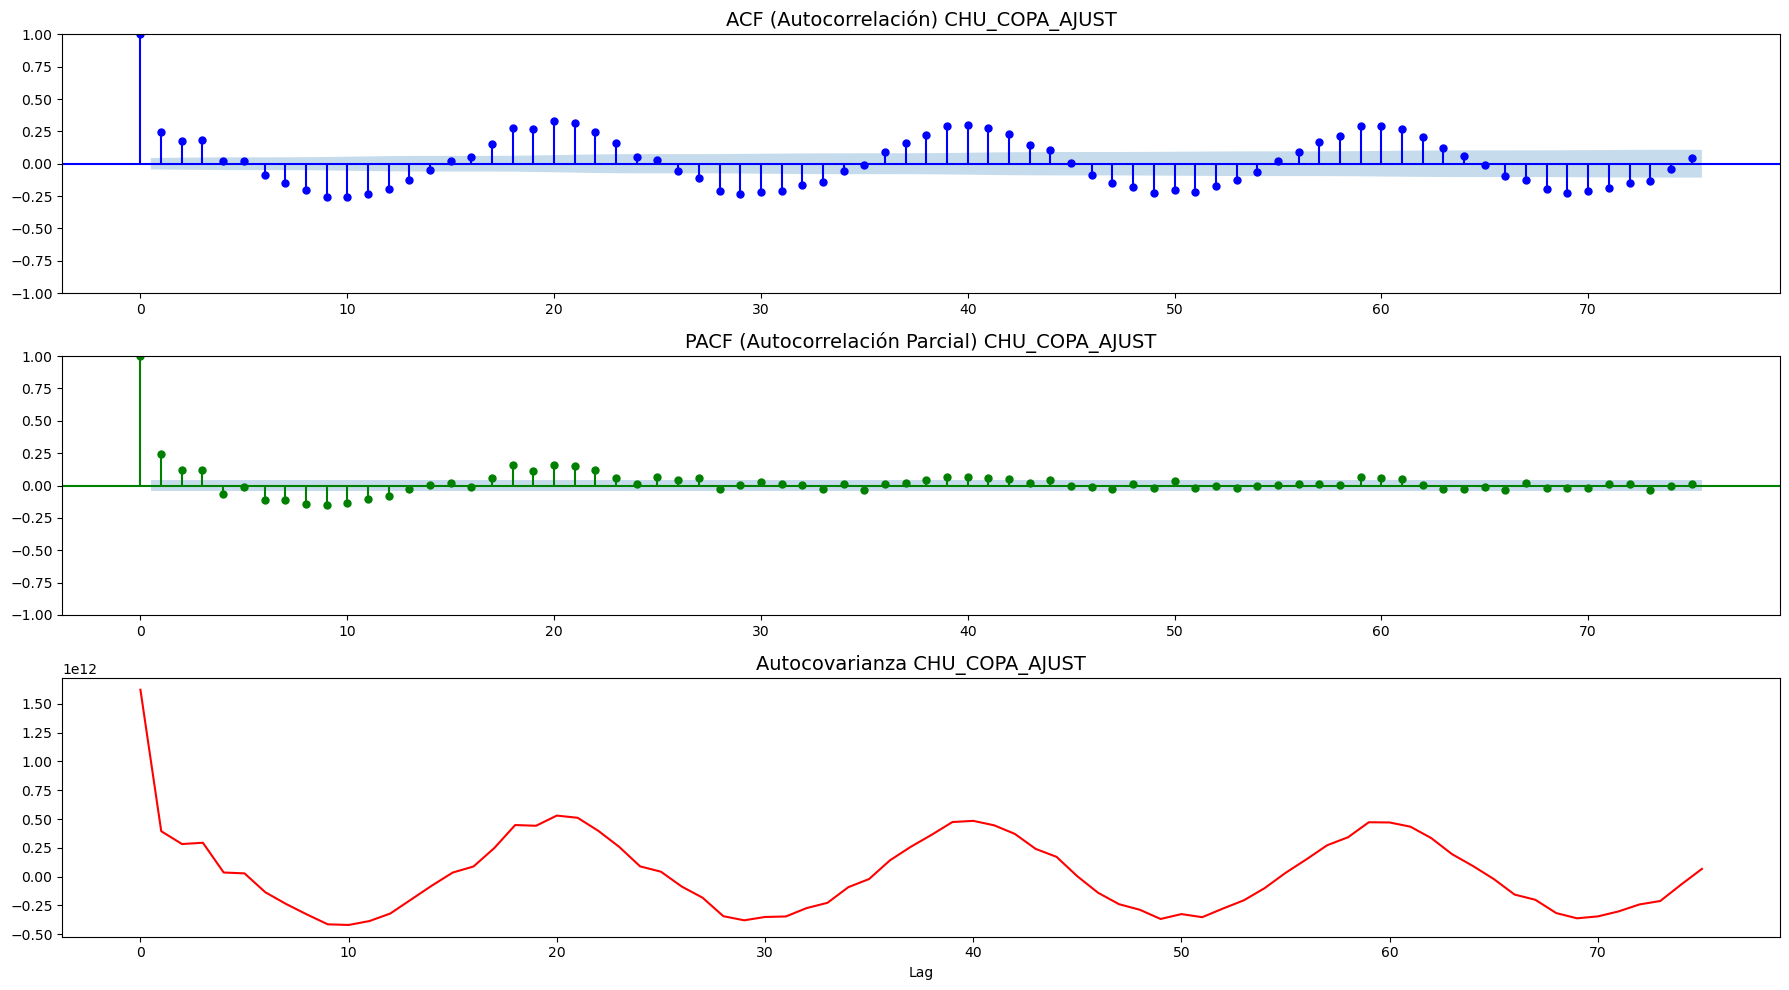

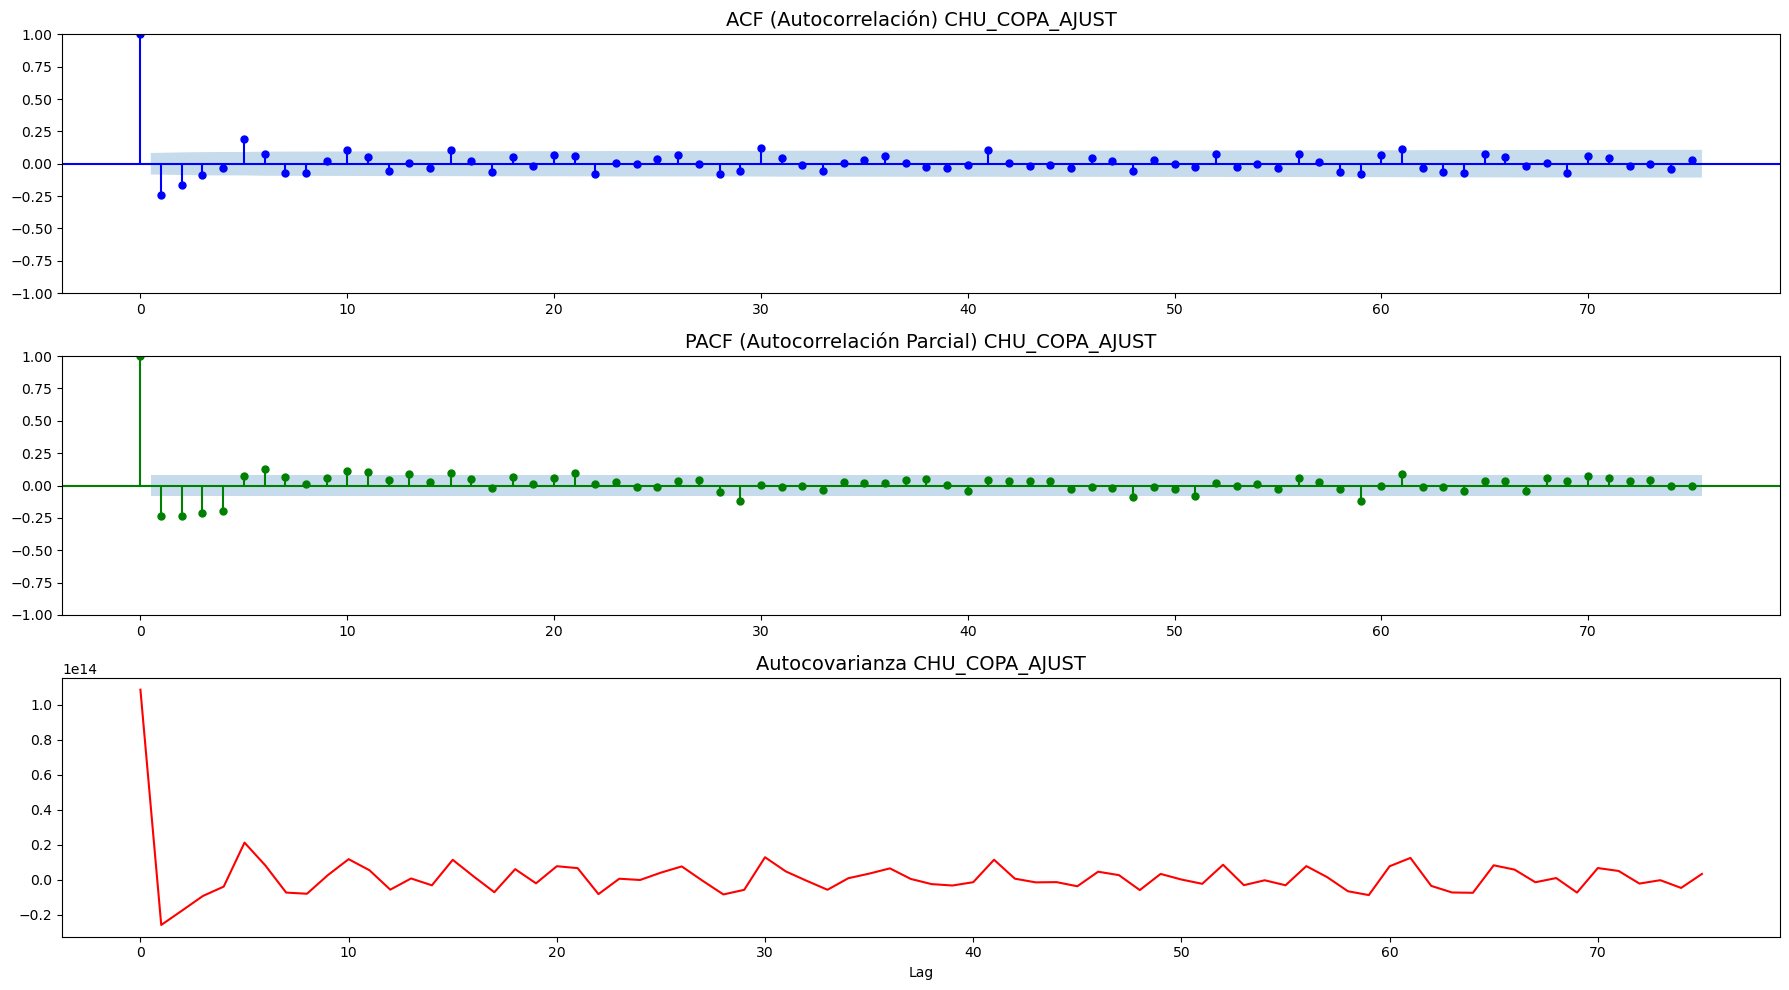

In [47]:
autocov_autocorr(dataframes[0],serie_titulo=dataframes[0].name)
autocov_autocorr(dataframes[1],serie_titulo=dataframes[0].name)
autocov_autocorr(dataframes[2],serie_titulo=dataframes[0].name)

*Vemos que en las tres series no hay estacionalidad porque no vemos picos que se repiten periodicamente. Parecen ser estancionarios, porque su PAC es sinusoidal y su PACF decrece exponencialmente.*

## Ejercicio 4
Realizar distintas pruebas de raíces unitarias para determinar si las series elegidas son o no estacionarias.

Test de Dickey Fuller

Estos tests se utilizan para determinar si una serie de tiempo es estacionaria o no.

In [48]:
def test_dickeyfuller(df):
    # ADF para la serie con "none" regression:  No incluye término independiente ni lineal (“None”)
    adf_none_df = adfuller(df, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)
    print("\nADF Test Results for df (None regression):")
    print('Estadistico ADF: %f' % adf_none_df[0])
    print('p-valor: %f' % adf_none_df[1])
    print('Valores criticos:')
    for key, valor in adf_none_df[4].items():
        print('\t%s: %.3f' % (key, valor))

    # ADF test con Drift: Incluya término independiente pero no incluye término lineal (“Drift”)
    adf_drift_df = adfuller(df, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    print("\nADF Test Results for df (Drift regression):")
    print('Estadistico ADF: %f' % adf_drift_df[0])
    print('p-valor: %f' % adf_drift_df[1])
    print('Valores criticos:')
    for key, valor in adf_drift_df[4].items():
        print('\t%s: %.3f' % (key, valor))

    # ADF test con Trend: Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
    adf_trend_df = adfuller(df, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)
    print("\nADF Test Results for df (Trend regression):")
    print('Estadistico ADF: %f' % adf_trend_df[0])
    print('p-valor: %f' % adf_trend_df[1])
    print('Valores criticos:')
    for key, valor in adf_trend_df[4].items():
        print('\t%s: %.3f' % (key, valor))


In [49]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
  print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
  dftest = adfuller(series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusion:====>")
    print("Rechazar la hipótesis nula")
    print("Los datos son estacionarios.")
  else:
    print("Conclusion:====>")
    print("No rechazar la hipótesis nula")
    print("Los datos no son estacionarios.")

In [36]:
print("CHU_COPA_AJUST")
test_dickeyfuller(dataframes[0])
print("---------------------------------------------------------------------")
print("CHU_REC_PROPIOS_AJUS")
test_dickeyfuller(dataframes[1])
print("---------------------------------------------------------------------")
print("CHU_REGALIAS_AJUST")
test_dickeyfuller(dataframes[2])
print("---------------------------------------------------------------------")

CHU_COPA_AJUST

ADF Test Results for df (None regression):
Estadistico ADF: -0.641313
p-valor: 0.437307
Valores criticos:
	1%: -2.567
	5%: -1.941
	10%: -1.617

ADF Test Results for df (Drift regression):
Estadistico ADF: -5.671137
p-valor: 0.000001
Valores criticos:
	1%: -3.435
	5%: -2.863
	10%: -2.568

ADF Test Results for df (Trend regression):
Estadistico ADF: -6.436652
p-valor: 0.000000
Valores criticos:
	1%: -3.965
	5%: -3.413
	10%: -3.129
---------------------------------------------------------------------
CHU_REC_PROPIOS_AJUS

ADF Test Results for df (None regression):
Estadistico ADF: -0.605548
p-valor: 0.452305
Valores criticos:
	1%: -2.567
	5%: -1.941
	10%: -1.617

ADF Test Results for df (Drift regression):
Estadistico ADF: -4.330791
p-valor: 0.000393
Valores criticos:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test Results for df (Trend regression):
Estadistico ADF: -4.656140
p-valor: 0.000829
Valores criticos:
	1%: -3.963
	5%: -3.413
	10%: -3.128
--------------------------

<b>Análisis de CHU_COPA_AJUST</b>

Test ADF sin drift ni tendencia:
* Estadístico ADF: -0.641313
* p-valor: 0.437307
* Interpretación: En este caso, el p-valor (0.437307) es mayor que los niveles de significancia comunes (0.01, 0.05, 0.1). Además, el estadístico ADF (-0.641313) es mayor que todos los valores críticos. Esto sugiere que no podemos rechazar la hipótesis nula de no estacionariedad. Es decir, según este test, la serie parece no ser estacionaria.

Test ADF con drift (constante):
* Estadístico ADF: -5.671137
* p-valor: 0.000001
* Interpretación: El p-valor es muy pequeño (0.000001 < 0.01) y el estadístico ADF (-5.671137) es menor que todos los valores críticos. Esto nos permite rechazar la hipótesis nula con un alto nivel de confianza. Según este test, la serie parece ser estacionaria alrededor de una constante.

Test ADF con tendencia:
* Estadístico ADF: -6.436652
* p-valor: 0.000000
* Interpretación: Al igual que en el caso anterior, el p-valor es extremadamente pequeño y el estadístico ADF es menor que todos los valores críticos. Podemos rechazar la hipótesis nula con un alto nivel de confianza. Este test sugiere que la serie es estacionaria alrededor de una tendencia.

Conclusión general:
Los resultados de estos tres tests muestran una imagen interesante:
* Sin considerar drift ni tendencia, la serie parece no estacionaria.
* Al considerar un término constante (drift), la serie muestra evidencia de estacionariedad.
* Al considerar tanto drift como tendencia, la serie muestra una fuerte evidencia de estacionariedad.

Esto sugiere que tu serie temporal probablemente tiene una tendencia y/o un nivel medio distinto de cero. La serie parece ser estacionaria una vez que se tienen en cuenta estos componentes.

Recomendaciones:
* Visualiza tu serie temporal para confirmar visualmente la presencia de una tendencia o un nivel medio distinto de cero.
* Considera diferenciar la serie si planeas usar modelos que requieran estacionariedad estricta.
* Si estás modelando la serie, podrías incluir términos de tendencia y/o constantes en tu modelo para capturar estos componentes.
* Ten en cuenta que la elección entre los modelos con drift y con tendencia dependerá de tu conocimiento del proceso que genera los datos y del comportamiento observado en la serie.

In [52]:
Augmented_Dickey_Fuller_Test_func(dataframes[0], dataframes[0].name)
print("------------------")
Augmented_Dickey_Fuller_Test_func(dataframes[1], dataframes[1].name)
print("------------------")
Augmented_Dickey_Fuller_Test_func(dataframes[2], dataframes[2].name)
print("------------------")

Resultados de la prueba de Dickey-Fuller para columna: CHU_COPA_AJUST
Test Statistic                -5.671137e+00
p-value                        8.916716e-07
No Lags Used                   2.200000e+01
Number of Observations Used    1.499000e+03
Critical Value (1%)           -3.434720e+00
Critical Value (5%)           -2.863470e+00
Critical Value (10%)          -2.567798e+00
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios.
------------------
Resultados de la prueba de Dickey-Fuller para columna: CHU_REC_PROPIOS_AJUST
Test Statistic                   -4.330791
p-value                           0.000393
No Lags Used                     26.000000
Number of Observations Used    1933.000000
Critical Value (1%)              -3.433737
Critical Value (5%)              -2.863036
Critical Value (10%)             -2.567567
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios.
------------------
Resultados de la prueba de Dic

A continuacion, analizamos mediante diferentes pruebas el orden de diferenciacion requerido para que la serie pueda llegar a ser estacionaria. Este es un analizis complementario, junto con los otros realizados. 
Las pruebas realizadas son:

* Prueba de Dickey-Fuller aumentada 
* Prueba de Kwiatkowski-Phillips-Schmidt-Shin
* Prueba de Phillips-Perron

In [44]:
def estacionario(y, name):
  print(name)
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))
  print("---------------------------------------------------------------------")

In [46]:
estacionario(dataframes[0], dataframes[0].name)
estacionario(dataframes[1], dataframes[1].name)
estacionario(dataframes[2], dataframes[2].name)

CHU_COPA_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------
CHU_REC_PROPIOS_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------
CHU_REGALIAS_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------


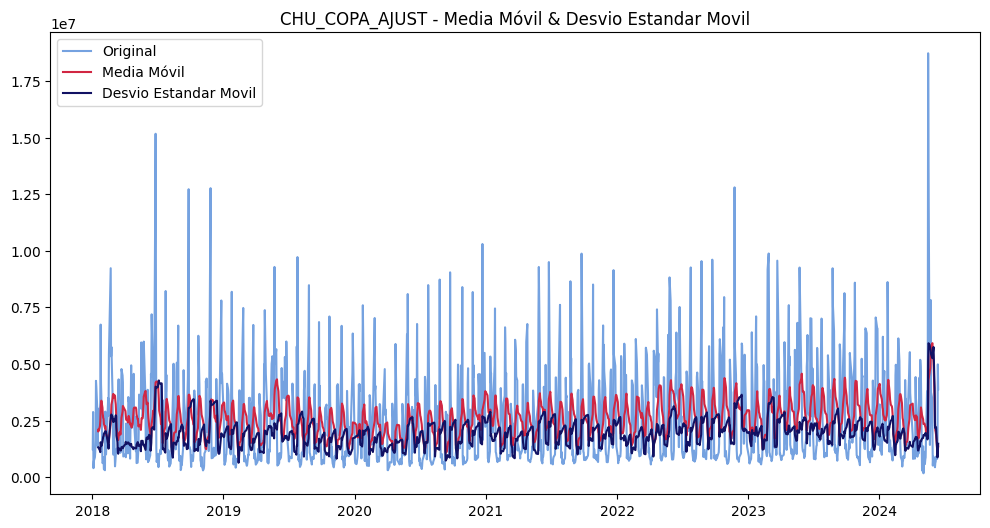

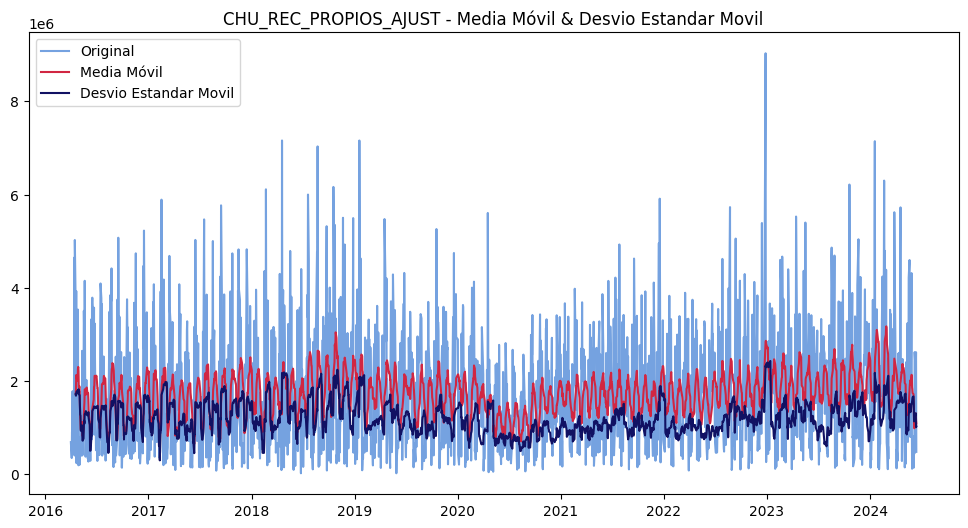

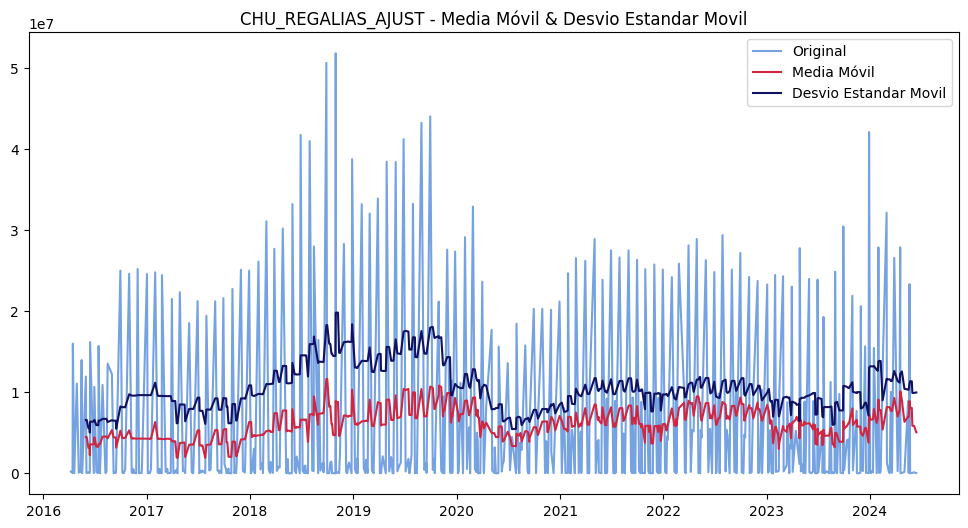

In [57]:
def test_stationarity(timeseries,name):
    # Rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(timeseries, color='#75a2e0', label='Original')
    ax.plot(rolmean, color='#d12642', label='Media Móvil')
    ax.plot(rolstd, color='#111163', label='Desvio Estandar Movil')
    ax.legend(loc='best')
    ax.set_title(f'{name} - Media Móvil & Desvio Estandar Movil')

    # Mostrar gráfico en Streamlit
    ax.plot()
test_stationarity(dataframes[0], dataframes[0].name)
test_stationarity(dataframes[1], dataframes[1].name)
test_stationarity(dataframes[2], dataframes[2].name)

Creamos primera serie diferenciada

In [54]:
dataframes_diff1 = [df_copa.diff(1).dropna(),
                    df_recprop.diff(1).dropna(),
                    df_regal.diff(1).dropna()]

Graficamos



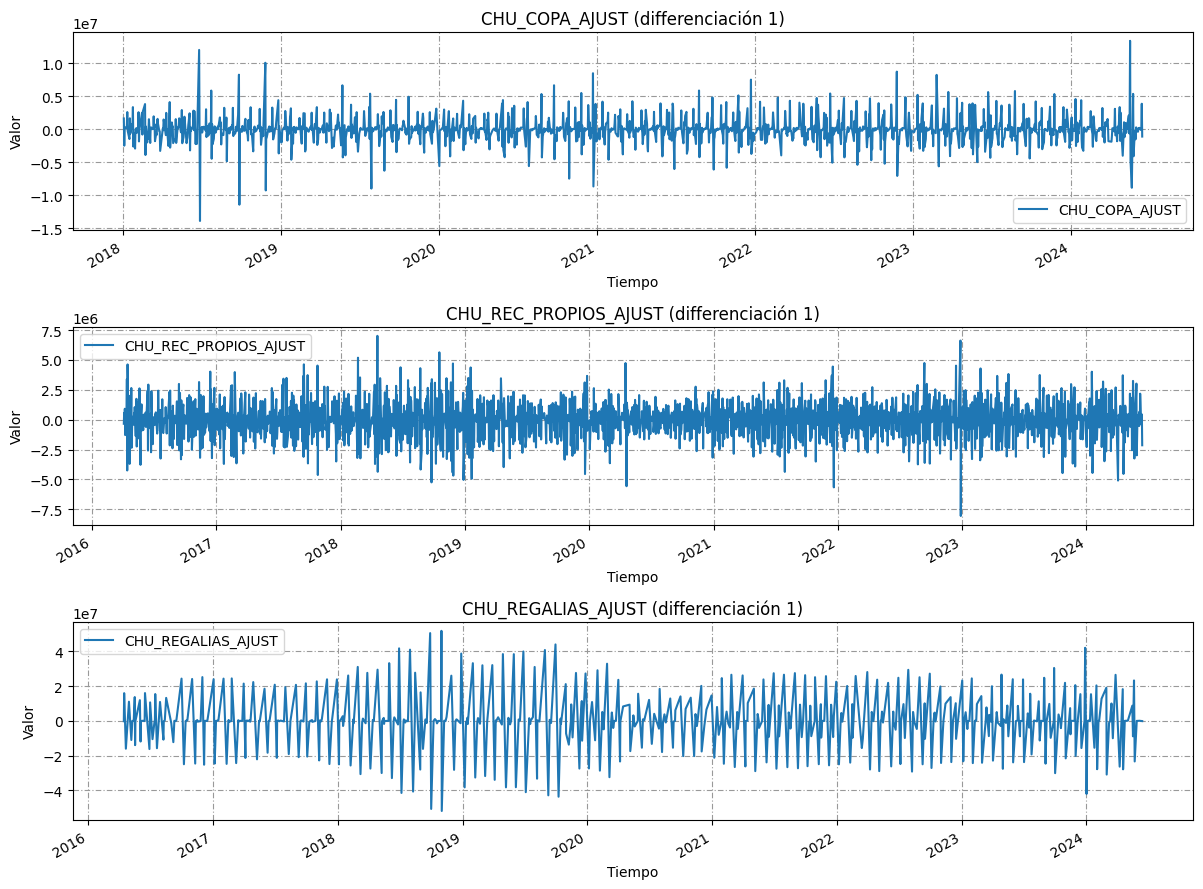

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), dpi=100)  # 3 filas, 1 columna

for i, (df, ax) in enumerate(zip(dataframes_diff1, axes)):
    graficar(serie=df,
             titulo=f"{df.name} (differenciación 1)",
             xlabel="Tiempo",
             ylabel="Valor",
             ax=ax)

plt.tight_layout() 
plt.show()

Volvemos a comprobar estacionariedad

In [61]:
estacionario(dataframes_diff1[0], dataframes_diff1[0].name)
estacionario(dataframes_diff1[1], dataframes_diff1[1].name)
estacionario(dataframes_diff1[2], dataframes_diff1[2].name)

CHU_COPA_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------
CHU_REC_PROPIOS_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------
CHU_REGALIAS_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------


*Vemos empíricamente que no es necesario diferenciar más porque las series son estacionarias.*

Graficamos correlograma

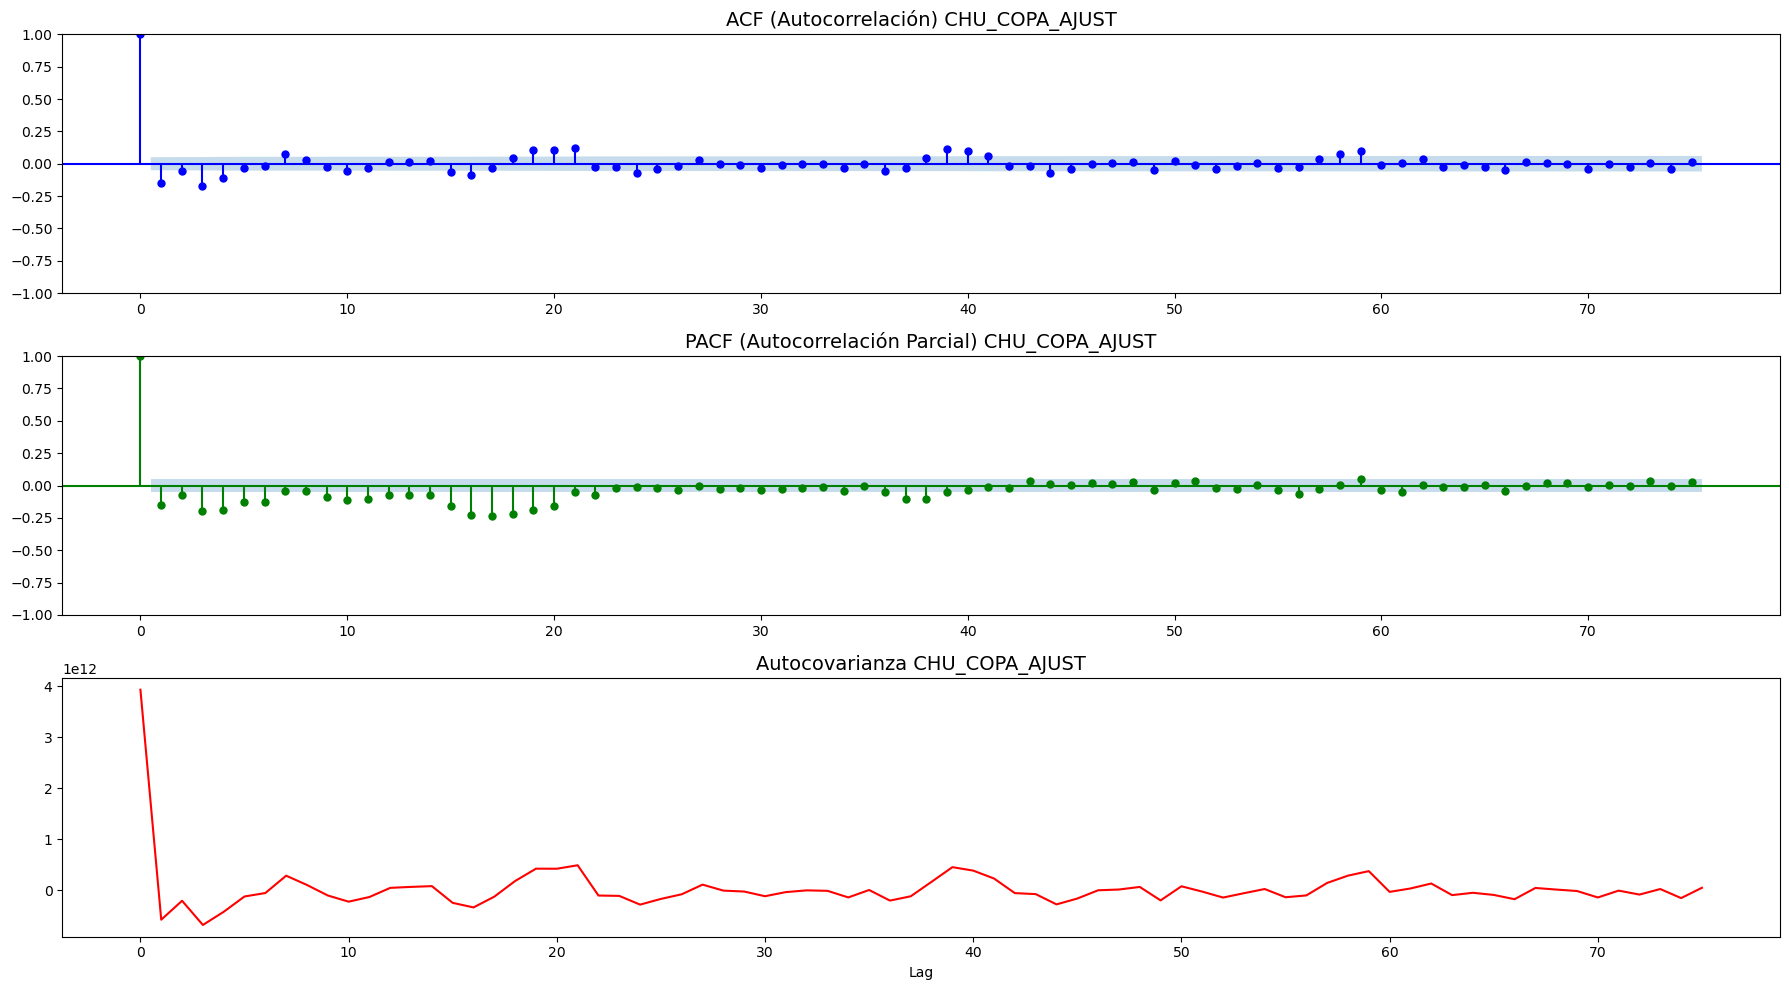

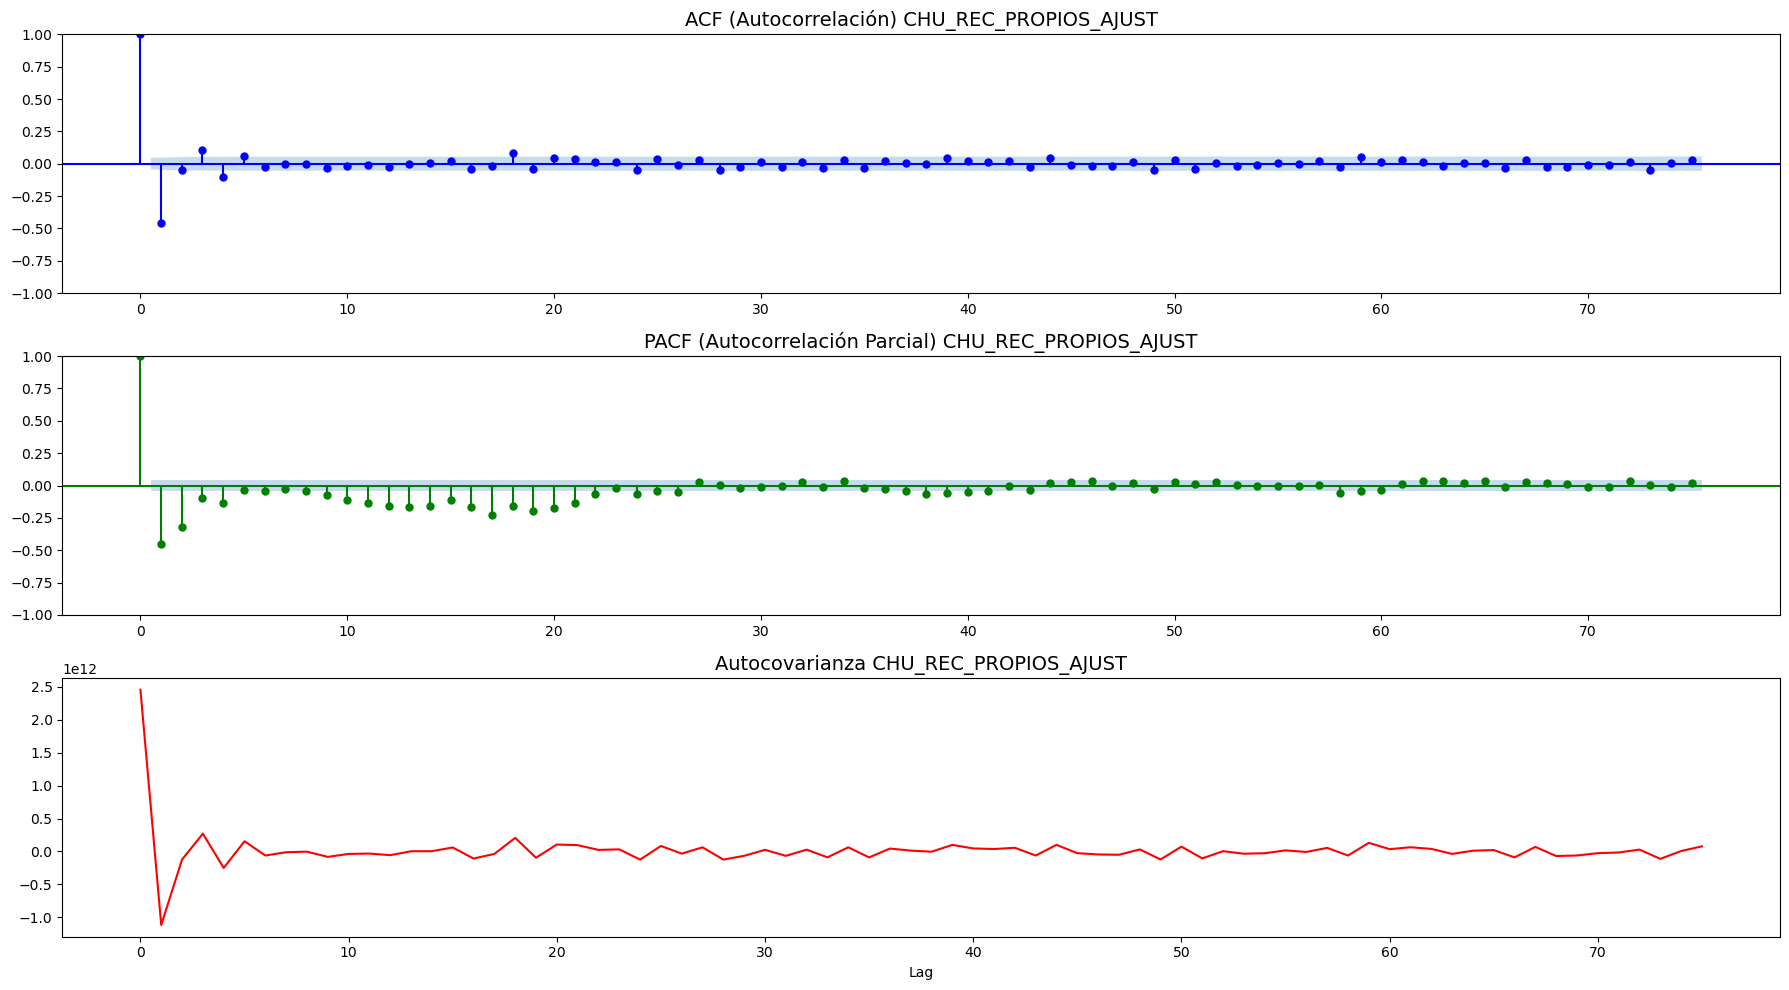

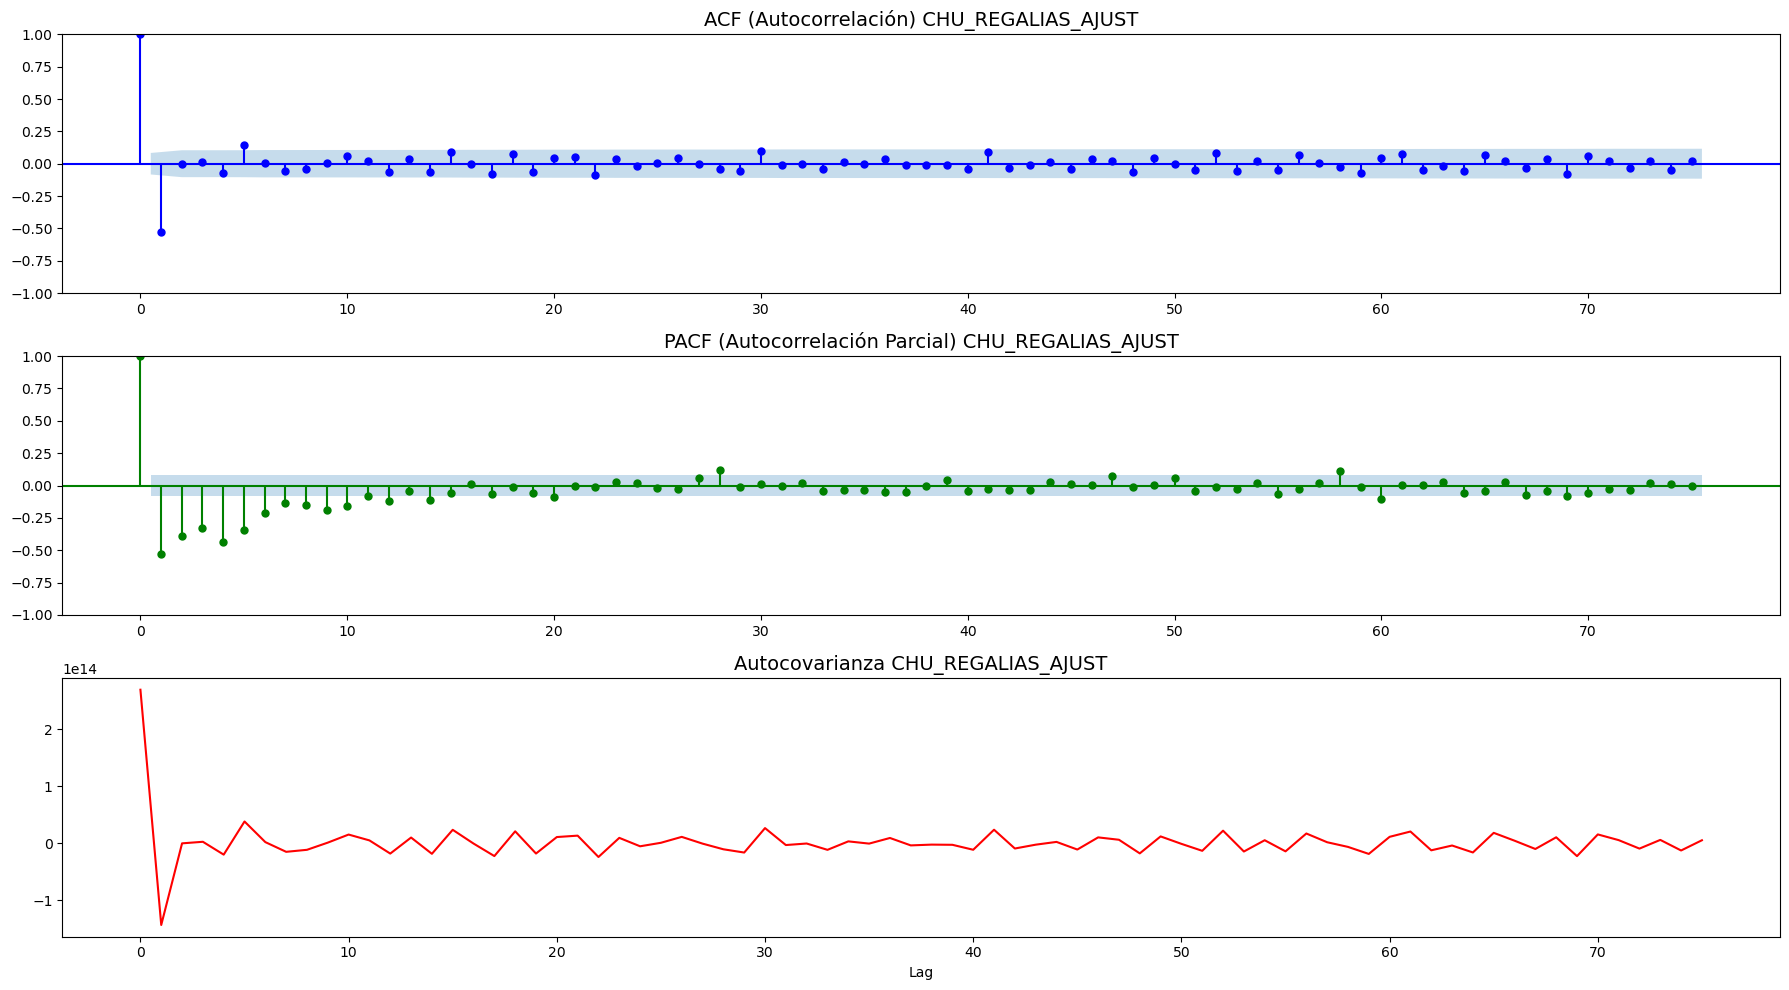

In [55]:
autocov_autocorr(dataframes_diff1[0],serie_titulo=dataframes_diff1[0].name)
autocov_autocorr(dataframes_diff1[1],serie_titulo=dataframes_diff1[1].name)
autocov_autocorr(dataframes_diff1[2],serie_titulo=dataframes_diff1[2].name)

*Vemos una caida exponencial en el ACF por lo que indica estacionariedad. También lo confirmamos con el test de Dickey Fuller.*

<h3>Auto Arima</h3>

<h4>CHU_COPA_AJUST</h4>

Serie original

In [56]:
aa_chu_copa_ajust = auto_arima(dataframes[0], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48429.166, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48397.674, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=48388.590, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48427.167, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=48105.704, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=48090.120, Time=0.74 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=48390.516, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=48053.122, Time=0.65 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=48330.549, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=48042.173, Time=1.01 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=48278.576, Time=0.48 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=48039.401, Time=0.97 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=48254.456, Time=0.33 sec
 ARIMA(5,1,2)(0,0,0)[0] i

Serie diferenciada

In [57]:
aa_chu_copa_ajust_diff = auto_arima(dataframes_diff1[0], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=48429.166, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48397.517, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=48388.451, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=48427.167, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=48105.545, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=48090.050, Time=0.60 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=48390.487, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=48052.651, Time=0.67 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=48330.536, Time=0.16 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=48041.628, Time=0.90 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=48278.543, Time=0.25 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=48038.824, Time=1.06 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=48254.427, Time=0.53 sec
 ARIMA(5,0,2)(0,0,0)[0] i

<h4>CHU_REC_PROPIOS_AJUST</h4>

Serie original

In [58]:
aa_rec_propios_ajus = auto_arima(dataframes[1], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61453.200, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61001.473, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60646.469, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61451.200, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=60553.491, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=60532.671, Time=1.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=60567.231, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=1.12 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 10.888 seconds


Serie diferenciada

In [60]:
aa_rec_propios_ajus_diff = auto_arima(dataframes_diff1[1], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=61453.200, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=61001.752, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=60646.095, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=61451.200, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=60553.248, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=60532.591, Time=1.57 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=60566.901, Time=0.45 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.98 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=2.45 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 13.813 seconds


<h4>CHU_REGALIAS_AJUST</h4>

Serie original

In [61]:
aa_rec_regalias_ajus = auto_arima(dataframes[2], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19413.446, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20020.519, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19838.808, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19554.705, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20018.520, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19420.168, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19507.084, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19408.886, Time=0.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19485.058, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=19398.444, Time=0.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=19420.548, Time=0.31 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=19398.829, Time=0.64 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=19394.091, Time=0.87 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=19411.679, Time=0.71 sec
 ARIMA(5,1,3)(0,0,0

Serie diferenciada

In [62]:
aa_rec_regalias_ajus_diff = auto_arima(dataframes_diff1[2], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=19414.437, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20020.519, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19839.139, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19555.197, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20018.519, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=19421.191, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=19507.753, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=19409.935, Time=0.74 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=19486.002, Time=0.24 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=19399.400, Time=0.42 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=19421.494, Time=0.27 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=19399.808, Time=0.79 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=19395.048, Time=1.01 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=19412.706, Time=0.93 sec
 ARIMA(5,0,3)(0,0,0

<h3>Modelos ARMA</h3>

In [63]:
import itertools
import statsmodels.api as sm

p_values = range(0, 8)
q_values = range(0, 8)

def modelo_arma(df):

    resultados = []
    mejor_aic = float("inf")
    mejor_order = None
    mejor_modelo = None


    for p, q in itertools.product(p_values, q_values):
        try:

            modelo = sm.tsa.arima.ARIMA(df, order=(p, 0, q))
            resultado = modelo.fit()

            aic = resultado.aic
            resultados.append((p, q, aic))

            if aic < mejor_aic:
                mejor_aic = aic
                mejor_order = (p, q)
                mejor_modelo = resultado

        except Exception as e:
            print(f"Error en el modelo ARMA({p},{q}): {e}")

    print(f"Mejor modelo ARMA: order={mejor_order} con AIC={mejor_aic}")

    for p, q, aic in resultados:
        print(f"ARMA({p},{q}) AIC: {aic}")

<h4>CHU_COPA_AJUST</h4>

Serie original

In [64]:
modelo_arma(dataframes[0])

Mejor modelo ARMA: order=(7, 3) con AIC=47826.601172494404
ARMA(0,0) AIC: 58272.379871856756
ARMA(0,1) AIC: 48196.62218682161
ARMA(0,2) AIC: 48052.29338240546
ARMA(0,3) AIC: 48042.23881656326
ARMA(0,4) AIC: 48046.40431844107
ARMA(0,5) AIC: 48046.42163525172
ARMA(0,6) AIC: 48025.399468476135
ARMA(0,7) AIC: 48019.06146223446
ARMA(1,0) AIC: 48080.507878541524
ARMA(1,1) AIC: 48073.892409004795
ARMA(1,2) AIC: 48044.057053558994
ARMA(1,3) AIC: 48032.983034702745
ARMA(1,4) AIC: 48002.96966225853
ARMA(1,5) AIC: 47996.948582084005
ARMA(1,6) AIC: 47992.17910704988
ARMA(1,7) AIC: 47994.82741201377
ARMA(2,0) AIC: 48068.60796900054
ARMA(2,1) AIC: 47992.575001316356
ARMA(2,2) AIC: 48028.249080816044
ARMA(2,3) AIC: 47986.68774985126
ARMA(2,4) AIC: 47900.650515929665
ARMA(2,5) AIC: 47906.0961260691
ARMA(2,6) AIC: 47873.14769999028
ARMA(2,7) AIC: 47999.35556644684
ARMA(3,0) AIC: 48025.398049719406
ARMA(3,1) AIC: 47991.248574237965
ARMA(3,2) AIC: 47989.43455056641
ARMA(3,3) AIC: 47987.924340309386
ARMA(

Serie diferenciada

In [65]:
modelo_arma(dataframes_diff1[0])

Mejor modelo ARMA: order=(6, 6) con AIC=47945.566252133365
ARMA(0,0) AIC: 58053.72033719762
ARMA(0,1) AIC: 48388.45047307691
ARMA(0,2) AIC: 48186.31895196305
ARMA(0,3) AIC: 48049.8918777838
ARMA(0,4) AIC: 48036.076920201594
ARMA(0,5) AIC: 48034.150124661515
ARMA(0,6) AIC: 48029.41571260011
ARMA(0,7) AIC: 47999.34444868531
ARMA(1,0) AIC: 48397.5168673474
ARMA(1,1) AIC: 48091.7199649976
ARMA(1,2) AIC: 48074.713295373556
ARMA(1,3) AIC: 48041.18654509759
ARMA(1,4) AIC: 48037.91713755678
ARMA(1,5) AIC: 48036.137806860075
ARMA(1,6) AIC: 48062.812294857154
ARMA(1,7) AIC: 47946.23048185493
ARMA(2,0) AIC: 48390.48692034454
ARMA(2,1) AIC: 48076.8811082928
ARMA(2,2) AIC: 48079.485053007615
ARMA(2,3) AIC: 48027.48847658491
ARMA(2,4) AIC: 47972.00644239384
ARMA(2,5) AIC: 48037.868770367524
ARMA(2,6) AIC: 48032.21524587585
ARMA(2,7) AIC: 47950.707447607514
ARMA(3,0) AIC: 48330.53606123651
ARMA(3,1) AIC: 48041.62814456869
ARMA(3,2) AIC: 47968.888478994486
ARMA(3,3) AIC: 47966.00352160711
ARMA(3,4) AI

<h4>CHU_REC_PROPIOS_AJUST</h4>

Serie original

In [66]:
modelo_arma(dataframes[1])

Mejor modelo ARMA: order=(6, 5) con AIC=60119.70922922789
ARMA(0,0) AIC: 73570.78995558868
ARMA(0,1) AIC: 60577.28678508628
ARMA(0,2) AIC: 60555.094077124886
ARMA(0,3) AIC: 60494.6224254603
ARMA(0,4) AIC: 60497.65045713
ARMA(0,5) AIC: 60489.61140430052
ARMA(0,6) AIC: 60489.48061499517
ARMA(0,7) AIC: 60490.55290857529
ARMA(1,0) AIC: 60554.30790778666
ARMA(1,1) AIC: 60518.517550815144
ARMA(1,2) AIC: 60514.52228887935
ARMA(1,3) AIC: 60493.06526475624
ARMA(1,4) AIC: 60500.410208209796
ARMA(1,5) AIC: 60492.44030168988
ARMA(1,6) AIC: 60462.10431111426
ARMA(1,7) AIC: 60448.659012345626
ARMA(2,0) AIC: 60526.6314282403
ARMA(2,1) AIC: 60516.86165371865
ARMA(2,2) AIC: 60515.334522944555
ARMA(2,3) AIC: 60490.14913416789
ARMA(2,4) AIC: 60498.205969257135
ARMA(2,5) AIC: 60475.70399763608
ARMA(2,6) AIC: 60131.8631248507
ARMA(2,7) AIC: 60191.310539248065
ARMA(3,0) AIC: 60498.54581493034
ARMA(3,1) AIC: 60491.50572132027
ARMA(3,2) AIC: 60493.482025712525
ARMA(3,3) AIC: 60170.97330943135
ARMA(3,4) AIC: 6

Serie diferenciada

In [67]:
modelo_arma(dataframes_diff1[1])

Mejor modelo ARMA: order=(7, 7) con AIC=60154.46444445962
ARMA(0,0) AIC: 74344.79066799424
ARMA(0,1) AIC: 60642.65719114389
ARMA(0,2) AIC: 60561.68112509533
ARMA(0,3) AIC: 60541.366370033546
ARMA(0,4) AIC: 60486.1358385631
ARMA(0,5) AIC: 60481.619187575125
ARMA(0,6) AIC: 60463.88162932804
ARMA(0,7) AIC: 60464.14444948674
ARMA(1,0) AIC: 61001.75205607649
ARMA(1,1) AIC: 60547.26175670116
ARMA(1,2) AIC: 60511.327033580856
ARMA(1,3) AIC: 60557.09861135097
ARMA(1,4) AIC: 60484.91858622787
ARMA(1,5) AIC: 60482.96305484377
ARMA(1,6) AIC: 60464.3553261529
ARMA(1,7) AIC: 60467.9798837533
ARMA(2,0) AIC: 60787.32358917783
ARMA(2,1) AIC: 60521.41350290384
ARMA(2,2) AIC: 60539.96226883473
ARMA(2,3) AIC: 60511.76686291294
ARMA(2,4) AIC: 60482.41932045196
ARMA(2,5) AIC: 60478.52665398749
ARMA(2,6) AIC: 60453.774809853116
ARMA(2,7) AIC: 60468.74348821903
ARMA(3,0) AIC: 60771.668060457254
ARMA(3,1) AIC: 60498.88799838879
ARMA(3,2) AIC: 60486.28641710864
ARMA(3,3) AIC: 60486.31117943903
ARMA(3,4) AIC: 6

<h4>CHU_REGALIAS_AJUST</h4>

Serie original

In [68]:
modelo_arma(dataframes[2])

Mejor modelo ARMA: order=(4, 5) con AIC=19414.869968988765
ARMA(0,0) AIC: 22510.74209686544
ARMA(0,1) AIC: 19487.089312819677
ARMA(0,2) AIC: 19470.32394247878
ARMA(0,3) AIC: 19470.9007245132
ARMA(0,4) AIC: 19461.28067763406
ARMA(0,5) AIC: 19439.68190880434
ARMA(0,6) AIC: 19440.82619793288
ARMA(0,7) AIC: 19441.923050433386
ARMA(1,0) AIC: 19520.776257600515
ARMA(1,1) AIC: 19475.329519734303
ARMA(1,2) AIC: 19471.84993529257
ARMA(1,3) AIC: 19430.929687105774
ARMA(1,4) AIC: 19431.949933438482
ARMA(1,5) AIC: 19441.03490073669
ARMA(1,6) AIC: 19443.132657750677
ARMA(1,7) AIC: 19443.85151735208
ARMA(2,0) AIC: 19491.583849652172
ARMA(2,1) AIC: 19466.814102125863
ARMA(2,2) AIC: 19448.80031517354
ARMA(2,3) AIC: 19445.176593180986
ARMA(2,4) AIC: 19446.38602377395
ARMA(2,5) AIC: 19438.90968956273
ARMA(2,6) AIC: 19440.5681914487
ARMA(2,7) AIC: 19436.33342823256
ARMA(3,0) AIC: 19467.638016830562
ARMA(3,1) AIC: 19460.04630311278
ARMA(3,2) AIC: 19447.477350366556
ARMA(3,3) AIC: 19446.88539991284
ARMA(3,

Serie diferenciada

In [69]:
modelo_arma(dataframes_diff1[2])

Mejor modelo ARMA: order=(3, 5) con AIC=19388.401680418712
ARMA(0,0) AIC: 22973.546614646955
ARMA(0,1) AIC: 19547.729780976115
ARMA(0,2) AIC: 19447.220325996524
ARMA(0,3) AIC: 19417.022052167245
ARMA(0,4) AIC: 19412.750721861375
ARMA(0,5) AIC: 19410.478103775036
ARMA(0,6) AIC: 19398.97965976871
ARMA(0,7) AIC: 19398.309890465825
ARMA(1,0) AIC: 19839.13858849556
ARMA(1,1) AIC: 19525.37764778643
ARMA(1,2) AIC: 19415.22659253968
ARMA(1,3) AIC: 19418.487939056307
ARMA(1,4) AIC: 19414.644352412404
ARMA(1,5) AIC: 19410.022844649968
ARMA(1,6) AIC: 19400.766343609463
ARMA(1,7) AIC: 19400.68936044105
ARMA(2,0) AIC: 19748.616187681706
ARMA(2,1) AIC: 19503.660620876024
ARMA(2,2) AIC: 19409.438524938378
ARMA(2,3) AIC: 19407.29312822646
ARMA(2,4) AIC: 19415.061141229668
ARMA(2,5) AIC: 19391.901113887776
ARMA(2,6) AIC: 19410.375985325183
ARMA(2,7) AIC: 19389.90167530964
ARMA(3,0) AIC: 19688.919186410138
ARMA(3,1) AIC: 19483.503450759345
ARMA(3,2) AIC: 19406.017820283094
ARMA(3,3) AIC: 19412.198032716

<h3> Métricas para modelos de autoarima automatico y manual </h3>

<h4>CHU_COPA_AJUST</h4>

Modelo 1: AUTOARIMA - ARIMA(1,0,2)(0,0,0)[0] intercept

In [82]:
modelo_aa_ARIMA_copa = sm.tsa.arima.ARIMA(dataframes[0], order=(1,1,2), trend='n')
resultado_aa_ARIMA_copa = modelo_aa_ARIMA_copa.fit()
resultado_aa_ARIMA_copa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1522
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -24029.622
Date:                Sat, 19 Oct 2024   AIC                          48067.244
Time:                        15:38:18   BIC                          48088.552
Sample:                             0   HQIC                         48075.176
                               - 1522                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4780      0.050      9.651      0.000       0.381       0.575
ma.L1         -0.8854      0.054    -16.487      0.000      -0.991      -0.780
ma.L2         -0.1109      0.053     -2.088      0.037      -0.215      -0.007
sigma2      3.574e+12   1.63e-14   2.19e+26      0.000    3.57e+12    3.57e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              5062.05
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             1.80
Prob(H) (two-sided):                  0.22   Kurtosis:                        11.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+41. Standard errors may be unstable.
"""

Modelo 2: AUTOARIMA - ARIMA(1,0,2)(0,0,0)[0] intercept

In [81]:
modelo_aa_ARIMA_copa_diff = sm.tsa.arima.ARIMA(dataframes_diff1[0], order=(1,0,2), trend='n')
resultado_aa_ARIMA_copa_diff = modelo_aa_ARIMA_copa_diff.fit()
resultado_aa_ARIMA_copa_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1521
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -24029.430
Date:                Sat, 19 Oct 2024   AIC                          48066.860
Time:                        15:38:13   BIC                          48088.169
Sample:                             0   HQIC                         48074.793
                               - 1521                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4817      0.049      9.757      0.000       0.385       0.578
ma.L1         -0.8902      0.054    -16.612      0.000      -0.995      -0.785
ma.L2         -0.1071      0.053     -2.015      0.044      -0.211      -0.003
sigma2      3.574e+12   1.62e-14   2.21e+26      0.000    3.57e+12    3.57e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              5092.83
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             1.81
Prob(H) (two-sided):                  0.21   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.48e+41. Standard errors may be unstable.
"""

Modelo 3: ARIMA manual - ARIMA(1,0,2)(0,0,0)[0] intercept

In [83]:
modelo_am_ARIMA_copa = sm.tsa.arima.ARIMA(dataframes[0], order=(7,0,3), trend='n')
resultado_am_ARIMA_copa = modelo_am_ARIMA_copa.fit()
resultado_am_ARIMA_copa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1522
Model:                 ARIMA(7, 0, 3)   Log Likelihood              -24014.606
Date:                Sat, 19 Oct 2024   AIC                          48051.212
Time:                        15:43:07   BIC                          48109.818
Sample:                             0   HQIC                         48073.029
                               - 1522                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2716      0.024    -11.369      0.000      -0.318      -0.225
ar.L2          1.3771      0.032     43.603      0.000       1.315       1.439
ar.L3          0.3382      0.047      7.198      0.000       0.246       0.430
ar.L4         -0.7582      0.050    -15.172      0.000      -0.856      -0.660
ar.L5          0.0921      0.053      1.748      0.080      -0.011       0.195
ar.L6          0.1868      0.037      5.113      0.000       0.115       0.258
ar.L7          0.0355      0.031      1.140      0.254      -0.026       0.097
ma.L1          0.8622      0.016     54.122      0.000       0.831       0.893
ma.L2         -0.8605      0.009    -96.848      0.000      -0.878      -0.843
ma.L3         -0.9868      0.016    -60.281      0.000      -1.019      -0.955
sigma2      3.355e+12   9.61e-15   3.49e+26      0.000    3.36e+12    3.36e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              5994.83
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             1.87
Prob(H) (two-sided):                  0.32   Kurtosis:                        11.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.11e+42. Standard errors may be unstable.
"""

In [84]:
modelo_am_ARIMA_copa_diff = sm.tsa.arima.ARIMA(dataframes_diff1[0], order=(6,0,6), trend='n')
resultado_am_ARIMA_copa_diff = modelo_am_ARIMA_copa_diff.fit()
resultado_am_ARIMA_copa_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1521
Model:                 ARIMA(6, 0, 6)   Log Likelihood              -23956.036
Date:                Sat, 19 Oct 2024   AIC                          47938.073
Time:                        15:43:17   BIC                          48007.325
Sample:                             0   HQIC                         47963.854
                               - 1521                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5233      0.392     -1.333      0.182      -1.293       0.246
ar.L2          0.1790      0.117      1.533      0.125      -0.050       0.408
ar.L3          0.4817      0.134      3.599      0.000       0.219       0.744
ar.L4          0.5420      0.205      2.646      0.008       0.141       0.943
ar.L5         -0.3933      0.165     -2.390      0.017      -0.716      -0.071
ar.L6         -0.2669      0.208     -1.285      0.199      -0.674       0.140
ma.L1          0.0525      0.393      0.133      0.894      -0.718       0.823
ma.L2         -0.6956      0.127     -5.459      0.000      -0.945      -0.446
ma.L3         -0.8074      0.279     -2.895      0.004      -1.354      -0.261
ma.L4         -0.5396      0.278     -1.938      0.053      -1.085       0.006
ma.L5          0.6987      0.135      5.171      0.000       0.434       0.963
ma.L6          0.3023      0.341      0.886      0.376      -0.367       0.971
sigma2       2.84e+12   2.19e-12    1.3e+24      0.000    2.84e+12    2.84e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              7025.64
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             2.05
Prob(H) (two-sided):                  0.23   Kurtosis:                        12.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+39. Standard errors may be unstable.
"""

<h4>CHU_REC_PROPIOS_AJUST</h4>

<h4>CHU_REGALIAS_AJUST</h4>

## Ejercicio 5

Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información/Selección y analizar significatividad individual y global de los parámetros del modelo).

In [85]:
# Model SARIMA
smodel_copa = auto_arima(dataframes[0],
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    m=12, # segun gpt recomiendas m=21 ya que 21 dias laborales en un mes.
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel_copa.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=48430.957, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=48429.166, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=48399.566, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=48390.541, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=48427.167, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=48388.590, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=48390.550, Time=0.33 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=48390.925, Time=0.81 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=48105.704, Time=0.28 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=48105.106, Time=0.85 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=48099.783, Time=2.40 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=48095.948, Time=4.11 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=10.82 sec
 ARIMA(1,1,1)(1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1522
Model:             SARIMAX(5, 1, 1)x(2, 0, 1, 12)   Log Likelihood              -24001.475
Date:                            Sat, 19 Oct 2024   AIC                          48024.950
Time:                                    15:58:22   BIC                          48083.548
Sample:                                         0   HQIC                         48046.765
                                           - 1522                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2246.6112   1948.342      1.153      0.249   -1572.069    6065.291
ar.L1          0.5518      0.022     25.636      0.000       0.510       0.594
ar.L2         -0.0063      0.035     -0.178      0.858      -0.075       0.063
ar.L3         -0.1537      0.043     -3.539      0.000      -0.239      -0.069
ar.L4         -0.0431      0.045     -0.948      0.343      -0.132       0.046
ar.L5         -0.0158      0.035     -0.452      0.651      -0.084       0.053
ma.L1         -0.9898      0.008   -117.340      0.000      -1.006      -0.973
ar.S.L12      -0.8431      0.203     -4.153      0.000      -1.241      -0.445
ar.S.L24      -0.1122      0.041     -2.759      0.006      -0.192      -0.032
ma.S.L12       0.7558      0.203      3.719      0.000       0.357       1.154
sigma2      3.489e+12   7.46e-06   4.68e+17      0.000    3.49e+12    3.49e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6233.02
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             1.92
Prob(H) (two-sided):                  0.29   Kurtosis:                        12.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.91e+32. Standard errors may be unstable.
"""

## Ejercicio 6

Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.

In [96]:
train_copa = dataframes[0].iloc[:round(len(dataframes[0])*.8)]
test_copa = dataframes[0].iloc[round(len(dataframes[0])*.8):]
print(f"Coparticipacion: train({train_copa.shape}), test({test_copa.shape})")

train_recursos = dataframes[1].iloc[:round(len(dataframes[1])*.8)]
test_recursos = dataframes[1].iloc[round(len(dataframes[1])*.8):]
print(f"Recursos: train({train_recursos.shape}), test({test_recursos.shape})")

train_regalias = dataframes[2].iloc[:round(len(dataframes[2])*.8)]
test_regalias = dataframes[2].iloc[round(len(dataframes[2])*.8):]
print(f"Regalias: train({train_regalias.shape}), test({test_regalias.shape})")

dataframes_train = [ train_copa, train_recursos, train_regalias ]
dataframes_test = [ test_copa, test_recursos, test_regalias ]

Coparticipacion: train((1218,)), test((304,))
Recursos: train((1568,)), test((392,))
Regalias: train((445,)), test((111,))


In [97]:
train_copa_diff1 = dataframes_diff1[0].iloc[:round(len(dataframes_diff1[0])*.8)]
test_copa_diff1 = dataframes_diff1[0].iloc[round(len(dataframes_diff1[0])*.8):]
print(f"Coparticipacion: train({train_copa_diff1.shape}), test({test_copa_diff1.shape})")

train_recursos_diff1 = dataframes_diff1[1].iloc[:round(len(dataframes_diff1[1])*.8)]
test_recursos_diff1 = dataframes_diff1[1].iloc[round(len(dataframes_diff1[1])*.8):]
print(f"Recursos: train({train_recursos_diff1.shape}), test({test_recursos_diff1.shape})")

train_regalias_diff1 = dataframes_diff1[2].iloc[:round(len(dataframes_diff1[2])*.8)]
test_regalias_diff1 = dataframes_diff1[2].iloc[round(len(dataframes_diff1[2])*.8):]
print(f"Regalias: train({train_regalias_diff1.shape}), test({test_regalias_diff1.shape})")

dataframes_train_diff1 = [ train_copa_diff1, train_recursos_diff1, train_regalias_diff1 ]
dataframes_test_diff1 = [ test_copa_diff1, test_recursos_diff1, test_regalias_diff1 ]

Coparticipacion: train((1217,)), test((304,))
Recursos: train((1567,)), test((392,))
Regalias: train((444,)), test((111,))


Modelo ARMA

In [91]:
modelo_arma(dataframes_train[0])

Mejor modelo ARMA: order=(7, 7) con AIC=38213.676797460714
ARMA(0,0) AIC: 46277.611203049906
ARMA(0,1) AIC: 38524.66655388468
ARMA(0,2) AIC: 38423.10952471495
ARMA(0,3) AIC: 38413.48833513366
ARMA(0,4) AIC: 38417.11379372391
ARMA(0,5) AIC: 38413.26075297864
ARMA(0,6) AIC: 38389.14984388891
ARMA(0,7) AIC: 38385.66803177551
ARMA(1,0) AIC: 38439.41708600268
ARMA(1,1) AIC: 38438.16193976407
ARMA(1,2) AIC: 38416.19337898911
ARMA(1,3) AIC: 38403.264625526805
ARMA(1,4) AIC: 38374.02616655296
ARMA(1,5) AIC: 38367.49695455799
ARMA(1,6) AIC: 38365.31509453387
ARMA(1,7) AIC: 38368.59148479366
ARMA(2,0) AIC: 38436.024450431316
ARMA(2,1) AIC: 38367.53893247071
ARMA(2,2) AIC: 38397.67053526704
ARMA(2,3) AIC: 38359.84873630568
ARMA(2,4) AIC: 38286.39345952231
ARMA(2,5) AIC: 38286.83866156821
ARMA(2,6) AIC: 38256.21033090074
ARMA(2,7) AIC: 38372.28448932178
ARMA(3,0) AIC: 38398.96690972541
ARMA(3,1) AIC: 38361.779743816274
ARMA(3,2) AIC: 38361.148182596175
ARMA(3,3) AIC: 38361.61906133732
ARMA(3,4) AI

In [98]:
modelo_arma(dataframes_train_diff1[0])

Mejor modelo ARMA: order=(7, 6) con AIC=38312.041299925346
ARMA(0,0) AIC: 46160.817008211605
ARMA(0,1) AIC: 38680.873759303955
ARMA(0,2) AIC: 38511.17570772038
ARMA(0,3) AIC: 38415.167222522985
ARMA(0,4) AIC: 38401.91004359669
ARMA(0,5) AIC: 38400.31084188026
ARMA(0,6) AIC: 38393.97665482806
ARMA(0,7) AIC: 38358.8666881846
ARMA(1,0) AIC: 38691.44740031622
ARMA(1,1) AIC: 38444.51456806743
ARMA(1,2) AIC: 38432.00611881279
ARMA(1,3) AIC: 38407.46995768667
ARMA(1,4) AIC: 38403.78520173004
ARMA(1,5) AIC: 38402.47198443824
ARMA(1,6) AIC: 38400.48788354859
ARMA(1,7) AIC: 38325.435912836256
ARMA(2,0) AIC: 38687.2622742298
ARMA(2,1) AIC: 38437.5823074253
ARMA(2,2) AIC: 38432.07173639474
ARMA(2,3) AIC: 38391.57526961541
ARMA(2,4) AIC: 38344.41864173135
ARMA(2,5) AIC: 38387.3456174536
ARMA(2,6) AIC: 38398.55837342673
ARMA(2,7) AIC: 38329.176505786745
ARMA(3,0) AIC: 38649.239480908174
ARMA(3,1) AIC: 38408.00677547496
ARMA(3,2) AIC: 38342.67529165503
ARMA(3,3) AIC: 38341.25526264146
ARMA(3,4) AIC: 

In [92]:
arma_model_copa = sm.tsa.arima.ARIMA(dataframes_train[0], order=(7,0,7), trend='n')
resultado_arma_model_copa = arma_model_copa.fit()
resultado_arma_model_copa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1218
Model:                 ARIMA(7, 0, 7)   Log Likelihood              -19195.309
Date:                Sat, 19 Oct 2024   AIC                          38420.617
Time:                        16:36:53   BIC                          38497.192
Sample:                             0   HQIC                         38449.441
                               - 1218                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3940      0.137    -10.140      0.000      -1.663      -1.125
ar.L2          0.5410      0.251      2.159      0.031       0.050       1.032
ar.L3          1.6710      0.132     12.695      0.000       1.413       1.929
ar.L4          0.2116      0.291      0.728      0.467      -0.358       0.781
ar.L5         -0.7022      0.220     -3.189      0.001      -1.134      -0.271
ar.L6          0.2110      0.110      1.918      0.055      -0.005       0.427
ar.L7          0.4615      0.073      6.326      0.000       0.319       0.605
ma.L1          1.9477      0.136     14.350      0.000       1.682       2.214
ma.L2          0.5696      0.328      1.736      0.083      -0.074       1.213
ma.L3         -1.4221      0.259     -5.490      0.000      -1.930      -0.914
ma.L4         -1.3013      0.206     -6.324      0.000      -1.705      -0.898
ma.L5         -0.2649      0.330     -0.803      0.422      -0.912       0.382
ma.L6         -0.2262      0.212     -1.067      0.286      -0.642       0.189
ma.L7         -0.2716      0.063     -4.340      0.000      -0.394      -0.149
sigma2      2.686e+12   2.26e-12   1.19e+24      0.000    2.69e+12    2.69e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3228.41
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.70
Prob(H) (two-sided):                  0.42   Kurtosis:                        10.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+39. Standard errors may be unstable.
"""

In [99]:
arma_model_copa_diff = sm.tsa.arima.ARIMA(dataframes_train_diff1[0], order=(7,0,6), trend='n')
resultado_arma_model_copa_diff = arma_model_copa_diff.fit()
resultado_arma_model_copa_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1217
Model:                 ARIMA(7, 0, 6)   Log Likelihood              -19140.458
Date:                Sat, 19 Oct 2024   AIC                          38308.916
Time:                        16:43:34   BIC                          38380.374
Sample:                             0   HQIC                         38335.815
                               - 1217                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4640      0.131      3.540      0.000       0.207       0.721
ar.L2          1.0452      0.143      7.334      0.000       0.766       1.324
ar.L3         -1.4451      0.153     -9.449      0.000      -1.745      -1.145
ar.L4          0.0557      0.192      0.290      0.772      -0.321       0.433
ar.L5          0.8886      0.123      7.224      0.000       0.647       1.130
ar.L6         -0.3948      0.078     -5.042      0.000      -0.548      -0.241
ar.L7         -0.1092      0.052     -2.115      0.034      -0.210      -0.008
ma.L1         -0.9455      0.132     -7.172      0.000      -1.204      -0.687
ma.L2         -1.0286      0.183     -5.627      0.000      -1.387      -0.670
ma.L3          1.7178      0.169     10.179      0.000       1.387       2.049
ma.L4         -0.5695      0.198     -2.876      0.004      -0.958      -0.181
ma.L5         -0.8313      0.151     -5.499      0.000      -1.128      -0.535
ma.L6          0.6625      0.087      7.575      0.000       0.491       0.834
sigma2      2.712e+12   5.58e-13   4.86e+24      0.000    2.71e+12    2.71e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.87   Jarque-Bera (JB):              4038.95
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             1.83
Prob(H) (two-sided):                  0.15   Kurtosis:                        11.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.78e+39. Standard errors may be unstable.
"""

Modelo ARIMA

In [93]:
arima_model_copa = auto_arima(dataframes_train[0], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=38401.440, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=38840.763, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38439.416, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38534.571, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39946.504, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=38419.194, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=38442.801, Time=0.40 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=38404.437, Time=0.72 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=38403.807, Time=0.58 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=38438.189, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=38416.920, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=38399.935, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=38398.967, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=38436.024, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0

In [100]:
arima_model_copa_diff = auto_arima(dataframes_train_diff1[0], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=38731.074, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38691.448, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38680.874, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=38729.074, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=38678.874, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=38689.448, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 4.057 seconds


In [94]:
arima_model_copa = sm.tsa.arima.ARIMA(dataframes_train[0], order=(4,0,0), trend='n')
resultado_arima_model_copa = arima_model_copa.fit()
resultado_arima_model_copa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1218
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -19304.305
Date:                Sat, 19 Oct 2024   AIC                          38618.610
Time:                        16:37:38   BIC                          38644.135
Sample:                             0   HQIC                         38628.218
                               - 1218                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7312      0.017     43.284      0.000       0.698       0.764
ar.L2          0.0868      0.036      2.411      0.016       0.016       0.157
ar.L3         -0.0892      0.043     -2.071      0.038      -0.174      -0.005
ar.L4          0.1208      0.034      3.603      0.000       0.055       0.186
sigma2      3.421e+12    4.7e-15   7.28e+26      0.000    3.42e+12    3.42e+12
===================================================================================
Ljung-Box (L1) (Q):                   4.65   Jarque-Bera (JB):              2267.16
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.96
Prob(H) (two-sided):                  0.37   Kurtosis:                         9.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.88e+41. Standard errors may be unstable.
"""

In [101]:
arima_model_copa_diff = sm.tsa.arima.ARIMA(dataframes_train_diff1[0], order=(0,0,1), trend='n')
resultado_arima_model_copa_diff = arima_model_copa_diff.fit()
resultado_arima_model_copa_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                 1217
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -19337.437
Date:                Sat, 19 Oct 2024   AIC                          38678.874
Time:                        16:45:24   BIC                          38689.082
Sample:                             0   HQIC                         38682.717
                               - 1217                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2467      0.016    -15.863      0.000      -0.277      -0.216
sigma2      3.712e+12   1.08e-15   3.44e+27      0.000    3.71e+12    3.71e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):              1461.85
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.59
Prob(H) (two-sided):                  0.69   Kurtosis:                         8.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.13e+42. Standard errors may be unstable.
"""

Modelo SARIMA

In [90]:
# Model SARIMA
smodel_copa = auto_arima(dataframes_train[0],
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    m=12, # segun gpt recomiendas m=21 ya que 21 dias laborales en un mes.
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel_copa.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=38801.836, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=38840.763, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=38439.624, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=38525.473, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=39946.504, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=38439.416, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=38438.708, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=38440.384, Time=0.66 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=38435.038, Time=0.78 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=38436.852, Time=1.87 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=38798.901, Time=0.62 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=38432.459, Time=0.97 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=38434.596, Time=0.43 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=38434.337, Time=2.38 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1218
Model:             SARIMAX(4, 0, 0)x(0, 0, [1], 12)   Log Likelihood              -19188.948
Date:                              Sat, 19 Oct 2024   AIC                          38391.897
Time:                                      16:30:47   BIC                          38427.632
Sample:                                           0   HQIC                         38405.348
                                             - 1218                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.56e+06   1.13e+05     13.829      0.000    1.34e+06    1.78e+06
ar.L1          0.5370      0.018     29.654      0.000       0.501       0.572
ar.L2          0.0331      0.034      0.976      0.329      -0.033       0.100
ar.L3         -0.1426      0.042     -3.374      0.001      -0.225      -0.060
ar.L4         -0.0627      0.038     -1.648      0.099      -0.137       0.012
ma.S.L12      -0.0695      0.036     -1.924      0.054      -0.140       0.001
sigma2      2.843e+12      0.085   3.36e+13      0.000    2.84e+12    2.84e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              3490.68
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.77
Prob(H) (two-sided):                  0.42   Kurtosis:                        10.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.43e+28. Standard errors may be unstable.
"""

## Ejercicio 7

Detallar una comparación con otros modelos estimados.


## Ejercicio 8

Efectuar un Análisis de Diagnóstico de las series temporales (Análisis sobre los Residuos del modelo, análisis gráfico de FAC, test de Ljung-Box, etc.).

## Ejercicio 9

Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.

##  Ejercicio 10
Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas.


## Ejercicio 11
Analizar la función impulso respuesta y realizar distintas pruebas para analizar la causalidad.

Justificar la elección del modelo con todo lo visto en clase. Es posible complementar con otros análisis

## Ejercicio 12

En caso de presentar estacionalidad alguna de las series elegidas, se solicita determinar la representación más adecuada mediante algún modelo SARIMA y comparar los resultados con los modelos determinados en el trabajo anterior.

(Opcional) Realizar la prueba de hipótesis de HEGY para testear la conjetura de raíz unitaria sobre las series elegidas.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9292b23b-d668-48da-87b9-72d6854ea93f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>